<a href="https://colab.research.google.com/github/Mounavanam/cs666student/blob/main/Copy_of_CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

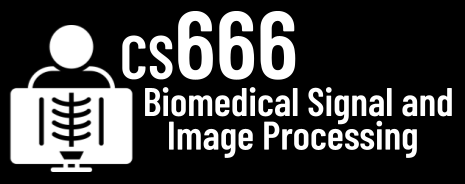
#Assignment 4

In [ ]:
# NAME: MOUNA VANAM

In [ ]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [3]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [ ]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [4]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [5]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')
img

array([[ 22,  24,  24, ...,  96,  94,  93],
       [ 23,  24,  24, ...,  97,  94,  92],
       [ 24,  24,  23, ...,  99,  96,  94],
       ...,
       [ 49,  50,  48, ..., 119, 119, 119],
       [ 50,  52,  53, ..., 123, 124, 123],
       [ 52,  53,  54, ..., 129, 128, 127]], dtype=uint8)

In [ ]:
# TODO: Please display this image and print the dimensions!

Img_dimensions: (1858, 2090)


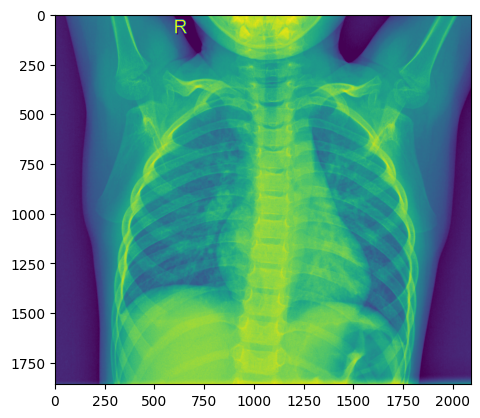

In [6]:
# TODO: YOUR CODE

img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')
plt.imshow(img)
print('Img_dimensions:', img.shape)

In [7]:
print('Img_dimensions:', img.shape)

Img_dimensions: (1858, 2090)


**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [10]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [8]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) loads and organizes the image data from 3 directories and stores the data in single list of numpy arrays called "data" with size of "(len(all_files), 300, 300)" .
# TODO: Operation 2) code converts the images to grayscale and resizes those greyscale images to a particular (fixed) size of(300,300).
# TODO: Operation 3) copies or assigns the resized image to a specific location in the NumPy array, whose location is determined by the index i within the images for the current directory.

In [11]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

First 5 Normal_Imgs:


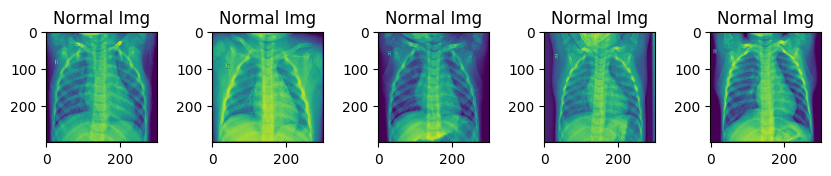

In [12]:
# TODO: YOUR CODE
###### plot for first 5 normal_images :
print('First 5 Normal_Imgs:')
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(data[0][i])
  plt.title('Normal Img')
plt.subplots_adjust(wspace = 0.5, hspace=0.5)

First 5 pneumonia_Imgs:


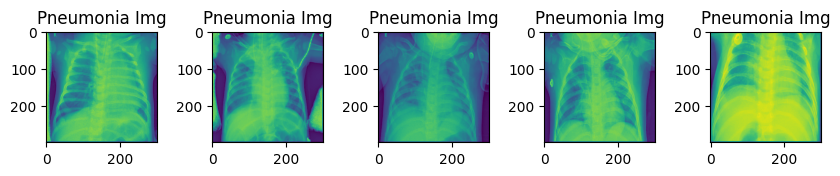

In [13]:
###### plot for first 5 pneumonia_images :

print('First 5 pneumonia_Imgs:')
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(data[1][i])
  plt.title('Pneumonia Img')
plt.subplots_adjust(wspace = 0.5, hspace=0.5)

**Task 3:** Setup training and testing data. [15 Points]

In [14]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [15]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [16]:
print(X_train)

[[0.16862746 0.15686275 0.19215687 ... 0.         0.         0.        ]
 [0.09019608 0.07450981 0.09019608 ... 0.         0.         0.        ]
 [0.03921569 0.07058824 0.09803922 ... 0.         0.         0.        ]
 ...
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.01062745 0.00117647 0.00278431 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [17]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.

TRAINING_COUNT = 60

y_train = np.zeros( TRAINING_COUNT * 3, dtype=np.int32 )
t_pos = 0

for i in range(3):
  y_train[t_pos:t_pos+TRAINING_COUNT] = i
  t_pos += TRAINING_COUNT

In [18]:
print(y_train)
print(y_train.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(180,)


In [19]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [20]:
print(X_test.shape)

(120, 90000)


In [21]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
# TODO

TESTING_COUNT = 40

y_test = np.zeros( TESTING_COUNT * 3, dtype=np.int32 )
t_pos = 0

for i in range(3):
  y_test[t_pos:t_pos+TESTING_COUNT] = i
  t_pos += TESTING_COUNT

In [22]:
print(y_test)
print(y_test.shape)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
(120,)


**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [23]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [24]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [25]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [ ]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [26]:
# TODO: YOUR ANSWER
#### Random Forest works by combining multiple decision trees to form a more accurate  classifier.
#### By using random subsets of the data and features to build each decision tree, the Random Forest can reduce overfitting and improve generalization to new and unseen data.
#### In this example,we are using the Random Forest Classifier algorithm to classify  X-ray images as normal, pneumonia or covid.

In [28]:
print(y_train)

[1 2 2 1 1 0 0 2 0 1 1 1 0 1 2 2 2 1 1 2 2 2 2 1 0 1 0 2 1 2 1 0 2 2 0 2 0
 0 1 0 2 0 2 2 0 1 1 2 0 1 1 2 1 0 0 2 2 2 2 1 0 2 2 0 0 2 2 0 2 1 0 0 0 0
 1 0 0 2 1 1 0 2 1 0 1 0 2 1 2 0 1 2 0 1 2 0 1 1 1 2 0 0 2 1 1 1 0 0 0 2 2
 1 0 1 1 0 0 0 1 1 2 1 1 2 1 0 2 0 0 0 0 2 2 2 1 2 0 1 1 2 2 1 0 2 2 0 1 0
 0 0 0 2 2 2 1 1 1 1 2 2 2 1 1 1 0 1 0 1 2 2 0 0 1 0 1 2 0 0 1 2]


In [29]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


In [27]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [ ]:
# TODO: YOUR ANSWER

####  Since the classification accuracy is 1 which is a 100% accuracy, this means that the Random Forest model was able to accurately predict the class of each sample in the test  dataset and it's not a surprise, because I think it is because the data is small. 
####  This would indicate that the classifier is performing  well on the given dataset.

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [34]:
# TODO: YOUR CODE AND YOUR ANSWER

TESTING_COUNT= 99
X_COVIDLEFT = np.zeros( (TESTING_COUNT, 300*300 ), dtype=np.float32)
t_pos = 0

for image in data[2][100:199]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_COVIDLEFT[t_pos] = image
    t_pos += 1

y_COVIDLEFT = np.full(TESTING_COUNT, 2)
clf.score(X_COVIDLEFT, y_COVIDLEFT)

0.9797979797979798

In [ ]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

Number of misclassified images: 2


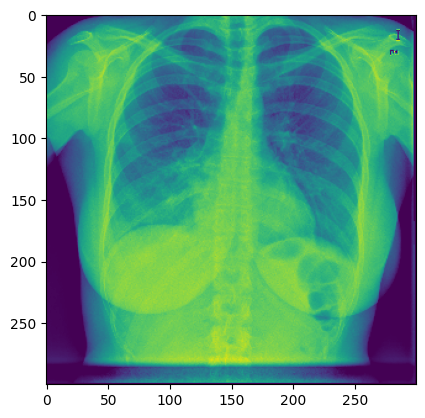

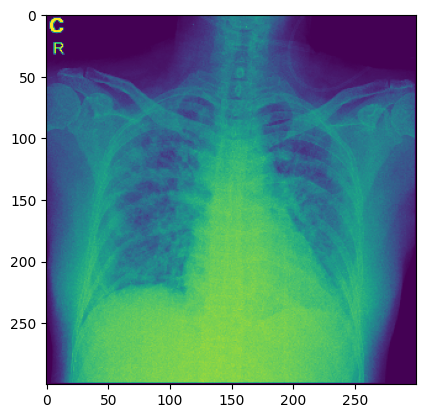

In [36]:
# TODO: YOUR CODE AND YOUR ANSWER
labels = clf.predict(X_COVIDLEFT)
misclassified_images = np.where(labels!=y_COVIDLEFT)[0]
print("Number of misclassified images:", len(misclassified_images))
import matplotlib.pyplot as plt
misclassified_images = X_COVIDLEFT[misclassified_images]
for i in range(len(misclassified_images)):
    plt.imshow(misclassified_images[i].reshape(300,300))
    plt.show()

In [ ]:
####By seeing at the images, it is difficult to predict why these images are misclassified. The randomly extracted features could have values that caused the misclassification.

In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw